In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from analysis_util import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch_util import *

import pickle
import seaborn as sns

import itertools


'''this script test the hypothesis whether people respond to a fixed bound
pepole  '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 






In [2]:

PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')


In [3]:
CODE_DIR = "/home/jenny/evidence-chain/"
FIG_DIR = os.path.join(CODE_DIR, "figs/xgb_local_position_evidence_acc/")


In [4]:

# Check if the directory exists
if not os.path.exists(FIG_DIR):
    # Create the directory
    os.makedirs(FIG_DIR)
    print(f"Directory '{FIG_DIR}' was created.")
else:
    print(f"Directory '{FIG_DIR}' already exists.")



Directory '/home/jenny/evidence-chain/figs/xgb_local_position_evidence_acc/' already exists.


In [5]:
stimdur = '250'
pos = 0
evaluate_mode = False

In [6]:

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']

if stimdur == '100':
    df = df[df['stimDur'] == 0.1]
if stimdur == '250':
    df = df[df['stimDur'] == 0.25]
# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]
# df = df[df['stimDur'] == 0.1]



/tmp/ipykernel_1579258/100844696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_1579258/100844696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_1579258/100844696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [7]:
# correct the count
df = correct_samples_by_condition(df)

cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()

In [8]:
df.shape

(3400, 13)

In [9]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected
0,2.6166679859161377,2611,[1],10,0,0.25,0.12,[-1. 1. -1. 1. -1. 1. -1. -1. -1. -1. -1. ...,0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...",s102,"[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -2.0, ...",9
1,2.2499890327453613,2233,[1],8,1,0.25,0.12,[-1. -1. -1. 1. 1. 1. 1. 1. -1. -1. -1. -...,0,"[-1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1...",s102,"[-1.0, -2.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...",7
2,2.1333320140838623,2118,[1],8,0,0.25,0.12,[ 1. -1. -1. -1. 1. 1. -1. -1. -1. -1. 1. ...,0,"[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...",s102,"[1.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, -2.0, ...",7
3,1.2833738327026367,1270,[1],5,1,0.25,0.12,[ 1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -...,0,"[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1....",s102,"[1.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ...",4
4,2.3333139419555664,2318,[1],9,1,0.25,0.12,[-1. 1. -1. 1. 1. -1. 1. 1. 1. -1. -1. -...,0,"[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1....",s102,"[-1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0...",8


In [10]:

# calculate terminated chains
cumsum_stop_list = []

for c in range(cumsum.shape[0]):
    cumsum_stop = cumsum[
        c, : int(count[c]+1)
    ]  # for example, if rt adjusted i 708, for 250ms, one have seen 3 stimulus.
    cumsum_stop_list.append(cumsum_stop)
 
level_at_response = [i[-1] for i in cumsum_stop_list]
resp = df['key'].tolist()

acc = []
bound = []
for num, k in zip(level_at_response, resp):
    if (num <= 0 and k == 0) or (num >= 0 and k == 1):
        acc.append(1)
    else:
        acc.append(0)
    bound.append(np.abs(num))
df['acc'] = acc
df['bound'] = bound

In [11]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [12]:
df.iloc[90:95]

,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected,acc,bound
90,1.5333139896392822,1522,[1],6,1,0.25,0.12,[-1. 1. 1. 1. 1. -1. 1. 1. -1. -1. -1. ...,1,"[-1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1....",s102,"[-1.0, 0.0, 1.0, 2.0, 3.0, 2.0, 3.0, 4.0, 3.0,...",5,1,2.0
91,1.9166650772094729,1914,[1],7,0,0.25,0.12,[-1. -1. -1. 1. -1. -1. -1. 1. 1. -1. -1. ...,1,"[-1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0,...",s102,"[-1.0, -2.0, -3.0, -2.0, -3.0, -4.0, -5.0, -4....",6,1,5.0
92,3.549971103668213,3538,[1],14,1,0.25,0.12,[ 1. 1. -1. -1. -1. 1. -1. 1. -1. -1. 1. ...,1,"[1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -...",s102,"[1.0, 2.0, 1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1....",13,1,2.0
93,2.1666481494903564,2152,[1],8,1,0.25,0.12,[ 1. -1. 1. -1. 1. 1. 1. 1. 1. -1. 1. -...,1,"[1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",s102,"[1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, ...",7,1,4.0
94,2.049988031387329,2033,[1],8,0,0.25,0.12,[ 1. -1. -1. -1. 1. 1. -1. 1. 1. 1. -1. -...,1,"[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1...",s102,"[1.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, 0.0, 1...",7,1,0.0


In [13]:


cumsum = np.array(df[df['acc']==1]['cumsum'].to_list())
sequence =  np.array(df[df['acc']==1]['sequence_clean'].to_list())
count = df[df['acc']==1]['count_corrected'].to_numpy()

chain_matrix = get_chain_matrix(sequence, count)



In [14]:
acc = df[df['acc']==1]['acc'].tolist() 
bound  = df[df['acc']==1]['bound'].tolist()

In [15]:
len(acc)

3146

In [16]:
# get the chains where 
chain_length = 0




In [17]:
ind = np.sum(~np.isnan(chain_matrix),axis=1)>=chain_length
chain_matrix2 = chain_matrix[ind,:]

valid_ind = np.argmax(np.isnan(chain_matrix2), axis=1) -1

In [18]:
chain_matrix_cumsum = np.cumsum(chain_matrix2, axis=1)

In [19]:
evidence = chain_matrix_cumsum[np.arange(0,len(valid_ind)), valid_ind]

In [20]:
chain_matrix3 = chain_matrix2.copy()
chain_matrix3[evidence<0] = chain_matrix3[evidence<0] * -1  # such that the chain is positive if it's towardd final choice

In [21]:
sequence_cumsum = np.cumsum(sequence, axis=1)
evidence_sequece = sequence_cumsum[:, -1]
sequence2 = sequence.copy()
sequence2[evidence_sequece<0] = sequence2[evidence_sequece<0] * -1

In [22]:
evidence[evidence<0]

array([-4., -2., -2., ..., -8., -5., -5.])

In [23]:
# generate permutations of all possible permutations

In [24]:

# Set the number of elements in each permutation
n = 4

# Generate all permutations of 1 and -1 of length n
perms = list(itertools.product([1, -1], repeat=n))



In [25]:

column_names = ['local_signal', 'chain_idx', 'pos_end', 'evidence_end', 'termination', 'acc']
df = pd.DataFrame(columns=column_names)

In [26]:
local_signal = []
chain_idx = []
pos_end =[]
evidence_end = []
termination = []
acc_if_term = []

for target in perms:
    target_length = len(target)   #length of 4
    for idx, chain in enumerate(chain_matrix3):
        ind_stop = np.argmax(np.isnan(chain))
        chain_cumsum = np.cumsum(chain)
        # within each chain
        for i in range(len(chain)-target_length+1):
            term = 0
            accuracy = 0
            if tuple(chain[i:i+target_length]) == target:
                local_signal.append(target)
                chain_idx.append(idx)
                pos_end.append(i+target_length)
                evidence_end.append(chain_cumsum[i+target_length-1])
                if i+target_length == ind_stop:
                    term =1
                    if acc[idx] == 1:
                       accuracy = 1 
                termination.append(term)
                acc_if_term.append(accuracy)

In [27]:
# evidence_end = np.abs(evidence_end)

In [28]:
data = {'local_signal': local_signal,
'chain_idx': chain_idx,
 'pos_end': pos_end,
# 'evidence_end': np.abs(evidence_end),
'evidence_end':evidence_end,

'termination': termination,
'acc': acc_if_term
}

df = pd.DataFrame(data)

In [29]:
mydict = {}
evidence_values = []
for target in perms:
    mydict[target] = None
    target_length = len(target)
    occurance =  0
    term = 0
    term_correct = 0
    for idx, chain in enumerate(chain_matrix3):
        ind_stop = np.argmax(np.isnan(chain))
        chain_cumsum = np.cumsum(chain)
        for i in range(len(chain)-target_length+1):
            
            if tuple(chain[i:i+target_length]) == target:
                occurance +=1
                if i+target_length == ind_stop:
                    term +=1
                    if acc[idx] == 1:
                        term_correct +=1 
    mydict[target] = [occurance, term, term/occurance, term_correct, term_correct/occurance]
    
    

In [30]:
mydict

{(1, 1, 1, 1): [2480, 727, 0.2931451612903226, 727, 0.2931451612903226],
 (1, 1, 1, -1): [1522, 308, 0.202365308804205, 308, 0.202365308804205],
 (1, 1, -1, 1): [1712, 228, 0.13317757009345793, 228, 0.13317757009345793],
 (1, 1, -1, -1): [813, 88, 0.10824108241082411, 88, 0.10824108241082411],
 (1, -1, 1, 1): [1979, 330, 0.1667508842849924, 330, 0.1667508842849924],
 (1, -1, 1, -1): [969, 110, 0.11351909184726522, 110, 0.11351909184726522],
 (1, -1, -1, 1): [970, 77, 0.07938144329896907, 77, 0.07938144329896907],
 (1, -1, -1, -1): [352, 12, 0.03409090909090909, 12, 0.03409090909090909],
 (-1, 1, 1, 1): [2056, 459, 0.2232490272373541, 459, 0.2232490272373541],
 (-1, 1, 1, -1): [1027, 138, 0.13437195715676728, 138, 0.13437195715676728],
 (-1, 1, -1, 1): [1059, 88, 0.08309726156751653, 88, 0.08309726156751653],
 (-1, 1, -1, -1): [410, 21, 0.05121951219512195, 21, 0.05121951219512195],
 (-1, -1, 1, 1): [1029, 94, 0.0913508260447036, 94, 0.0913508260447036],
 (-1, -1, 1, -1): [418, 18, 0.04

In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

In [32]:
dataset = np.zeros((len(df), 6))

Text(0.5, 0, 'evidence')

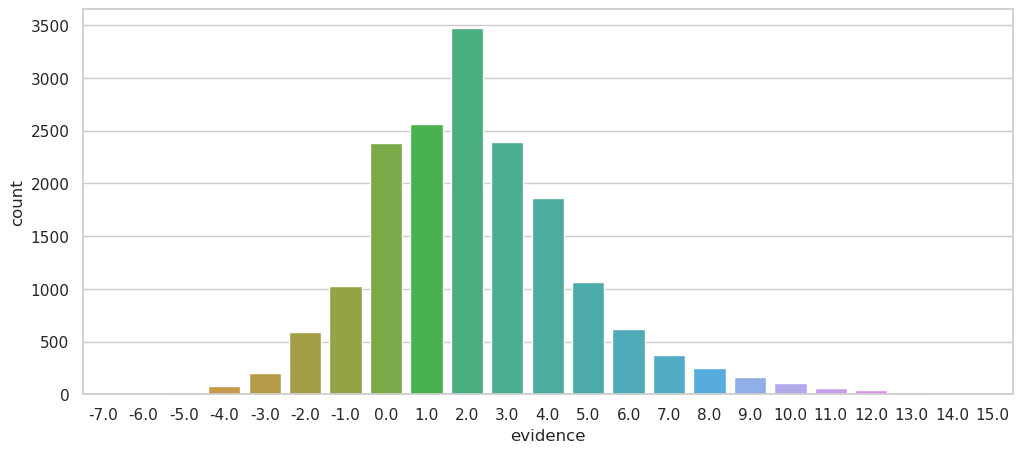

In [33]:
fig, ax = plt.subplots(1, figsize = (12,5))
sns.countplot(x=df['evidence_end'],ax = ax)
ax.set_xlabel("evidence")

In [34]:
sum(df['evidence_end'] >=9) /len(df)

0.02285450453050153

In [35]:
ind = df['evidence_end'] <=8

In [36]:
local_signal_array = [np.array(i) for i in local_signal]

In [37]:
dataset[:,0:4] = local_signal_array

In [38]:
dataset[:,4] = evidence_end
dataset[:,5] = pos_end

In [39]:
list_of_feautres = ["local_0", "local_1", "local_2", "local_3", "evidence", "position"]

In [40]:
# one hot encode 
# dataset[:,0:4][dataset[:,0:4] == -1] = 0

In [41]:
dataset_resp = np.array(termination)

In [42]:
dataset = dataset[:,0:6]
list_of_feautres = list_of_feautres[0:6]

In [43]:
dataset.shape

(17327, 6)

In [44]:
# select the low evidence trials

dataset = dataset[ind,:]

In [45]:
dataset_resp = dataset_resp[ind]

In [46]:
    # train test val split
x_train, x_test, y_train, y_test = train_test_split(
    dataset, dataset_resp, test_size=0.2, random_state=1
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.25, random_state=1
)

In [47]:


# create a dictionary containing the hyperparameters
# to tune and the range of values to try
PARAMETERS = {
    "subsample": [0.75, 1],
    "gamma": [0.5, 1.5, 5],
    "colsample_bytree": [0.75, 1],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 5],
    #               "tree_method":['gpu_hist'],
    "learning_rate": [0.1, 0.01, 0.05],
}


# create a validation set which will be used for early stopping
eval_set = [(x_train, y_train), (x_val, y_val)]
# initialise an XGBoost classifier, set the number of estimators,
# evaluation metric & early stopping rounds
estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=100,
    seed=42
    #                             tree_method = 'gpu_hist',
    #                              gpu_id =1
)

# initialise GridSearchCV model by passing the XGB classifier we
# initialised in the last step along with the dictionary of parameters
# and values to try. We also set the number of folds to validate over
# along with the scoring metic to use
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=PARAMETERS,
    cv=7,
    n_jobs=10,
    verbose=0,
    scoring="roc_auc",
    return_train_score=True,
)

In [48]:
# fit model
clf = grid_search.fit(
    x_train,
    y_train,
    eval_set=eval_set,
    eval_metric=["auc"],
    early_stopping_rounds=10,
    verbose=0,
)


/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-lea

In [49]:
print(clf.best_score_, clf.best_params_)

0.711796720950094 {'colsample_bytree': 1, 'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.75}


In [50]:
mymodel = clf.best_estimator_

In [51]:
mymodel

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [52]:
mymodel.fit(
    x_train,
    y_train,
    early_stopping_rounds=15,
    eval_metric=["auc", "logloss"],
    eval_set=eval_set,
    verbose=False,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

0.737095526346609
0.6994791259988027
0.7103368516855151


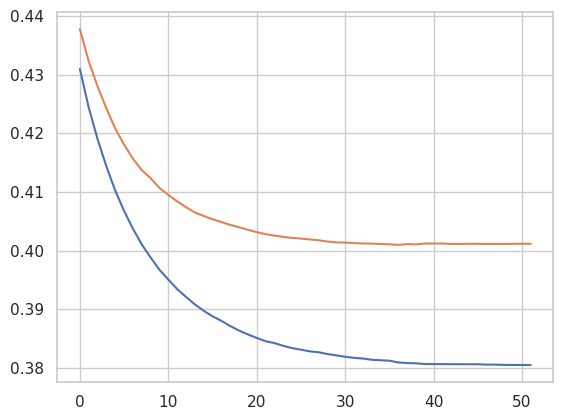

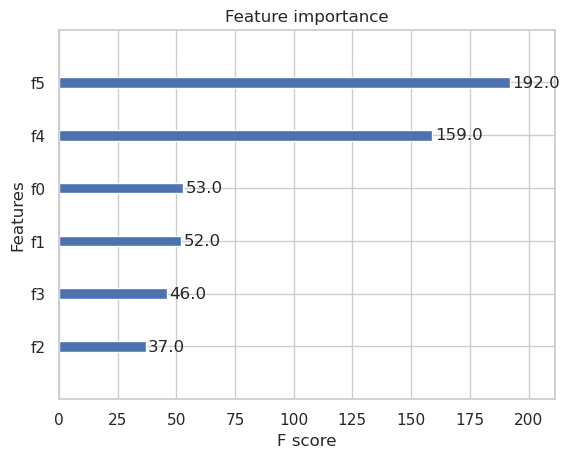

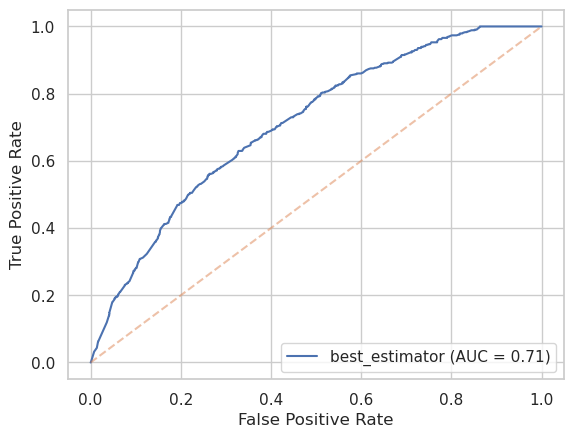

In [53]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob_train = mymodel.predict_proba(x_train)
y_pred_prob_val = mymodel.predict_proba(x_val)

y_pred_prob_test = mymodel.predict_proba(x_test)






fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_pred_prob_train[:, 1])
fpr_val, tpr_val, _ = metrics.roc_curve(y_val, y_pred_prob_val[:, 1])
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred_prob_test[:, 1])

auc_train = metrics.auc(fpr_train, tpr_train)
auc_val = metrics.auc(fpr_val, tpr_val)
auc_test = metrics.auc(fpr_test, tpr_test)

print(auc_train)
print(auc_val)
print(auc_test)


results = mymodel.evals_result()
plt.plot(results["validation_0"]["logloss"])
plt.plot(results["validation_1"]["logloss"])
x_train.shape
booster: xgb.Booster = mymodel.get_booster()
xgb.plot_importance(booster, grid=True, importance_type="weight")
scores = mymodel.predict_proba(x_test)

fpr, tpr, thresh = metrics.roc_curve(y_test, scores[:, 1])

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="best_estimator"
)
display.plot()
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "--", alpha=0.5)
plt.show()




In [54]:
mymodel

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [55]:
from sklearn.inspection import PartialDependenceDisplay

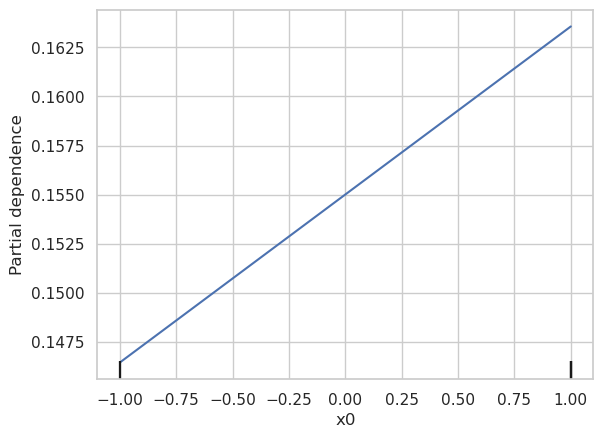

In [56]:
PartialDependenceDisplay.from_estimator(mymodel, x_train, [0])

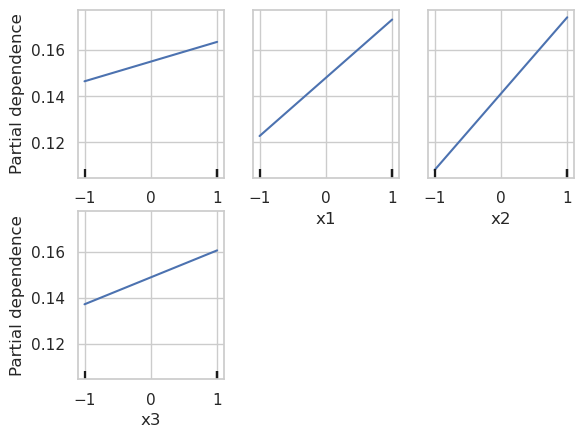

In [57]:

a = PartialDependenceDisplay.from_estimator(mymodel, x_train, [0,1,2,3])


In [58]:
from sklearn.inspection import partial_dependence

partial_dependence(mymodel, x_train, [1])


/home/jenny/anaconda3/envs/echain/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


{'grid_values': [array([-1.,  1.])],
 'values': [array([-1.,  1.])],
 'average': array([[0.1227087 , 0.17326447]], dtype=float32)}

In [59]:
partial_dependence(mymodel, x_train, [0,1,2])


{'grid_values': [array([-1.,  1.]), array([-1.,  1.]), array([-1.,  1.])],
 'values': [array([-1.,  1.]), array([-1.,  1.]), array([-1.,  1.])],
 'average': array([[[[0.08385894, 0.12207685],
          [0.11272942, 0.17824025]],
 
         [[0.09142808, 0.1395272 ],
          [0.11831064, 0.2032464 ]]]], dtype=float32)}

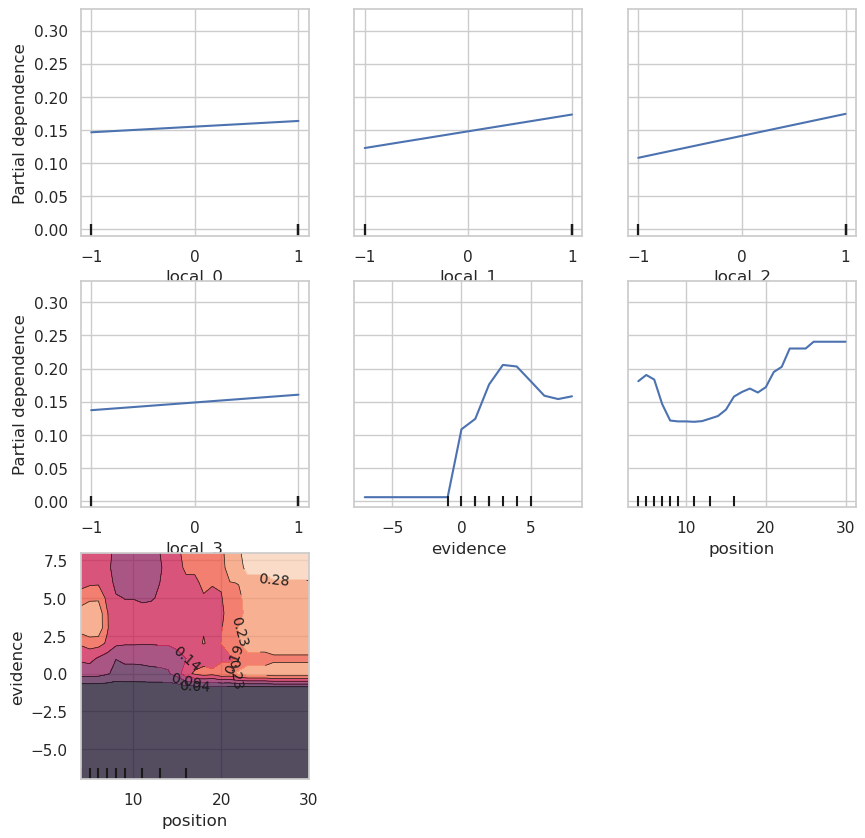

In [61]:
handle = PartialDependenceDisplay.from_estimator(mymodel, x_train, [0, 1,2,3,4, 5, (5, 4)], feature_names = list_of_feautres)
fig, axes = handle.figure_, handle.axes_
fig.set_figwidth(10)
fig.set_figheight(10)

heatmap = handle.heatmaps_

In [62]:
list_of_feautres

['local_0', 'local_1', 'local_2', 'local_3', 'evidence', 'position']

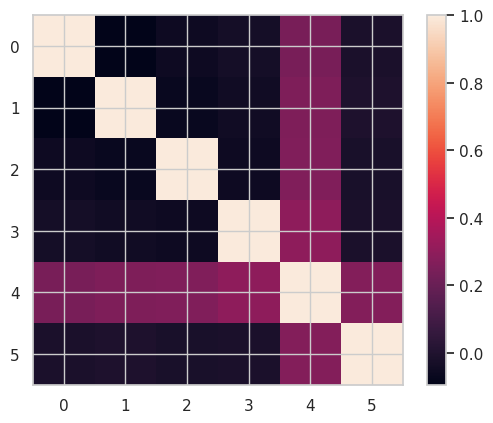

In [63]:
corr_coef = np.corrcoef(x_train.T, rowvar= True)
plt.imshow(corr_coef)
plt.colorbar()

In [64]:
corr_coef[np.triu_indices(4)]

array([ 1.        , -0.09396932, -0.05453392, -0.03271434,  1.        ,
       -0.06544757, -0.04428933,  1.        , -0.0521131 ,  1.        ])

In [65]:
corr_coef

array([[ 1.        , -0.09396932, -0.05453392, -0.03271434,  0.2407188 ,
        -0.01672095],
       [-0.09396932,  1.        , -0.06544757, -0.04428933,  0.25755105,
        -0.00833269],
       [-0.05453392, -0.06544757,  1.        , -0.0521131 ,  0.26266617,
        -0.01945648],
       [-0.03271434, -0.04428933, -0.0521131 ,  1.        ,  0.29892237,
        -0.01301092],
       [ 0.2407188 ,  0.25755105,  0.26266617,  0.29892237,  1.        ,
         0.27257664],
       [-0.01672095, -0.00833269, -0.01945648, -0.01301092,  0.27257664,
         1.        ]])

In [67]:
# for position_terminate in position_range:

#     column_names = ['local_signal', 'chain_idx', 'pos_end', 'evidence_end', 'termination', 'acc']
#     df_ = pd.DataFrame(columns=column_names)
#     indices = np.arange(len(chain_matrix))
#     dataset, dataset_resp = make_dataset(position_terminate, count, chain_matrix)
